In [ ]:
import os
from pathlib import Path

import pandas as pd
from matplotlib import pyplot as plt

# Get the old and new data directories
list_of_commits = list(Path("../../logs/performance/git_heads").glob("*/"))

list_of_commits.sort(key=os.path.getmtime, reverse=True)
list_of_commits = list_of_commits[:2]
list_of_files_new = list(Path(list_of_commits[0] / "all").glob("*.csv"))
list_of_files_old = list(Path(list_of_commits[1] / "all").glob("*.csv"))

latest_file_new = max(list_of_files_new, key=os.path.getctime)
latest_file_old = max(list_of_files_old, key=os.path.getctime)

df_latest_new = pd.read_csv(latest_file_new)
df_latest_old = pd.read_csv(latest_file_old)


# format: timestamp,category,test_name,query,scenario,execution_time,results_consistent,fainder_mode,num_results,ids,num_terms,id_str


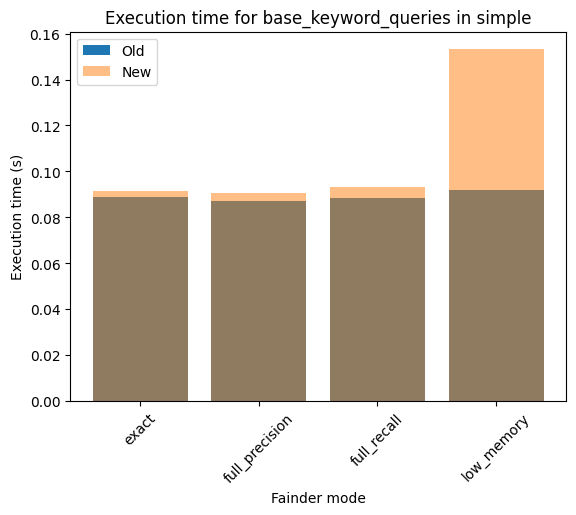

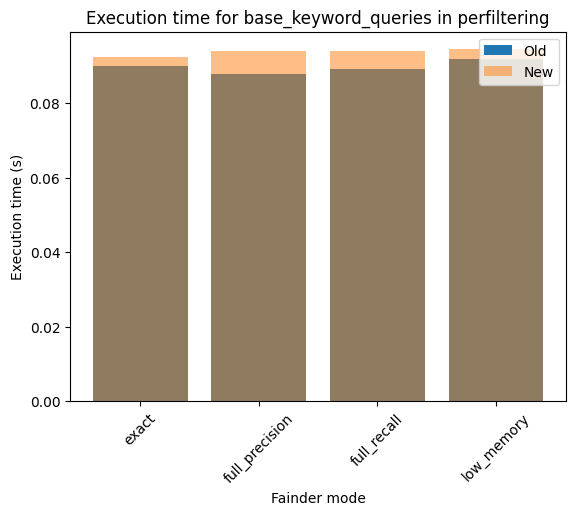

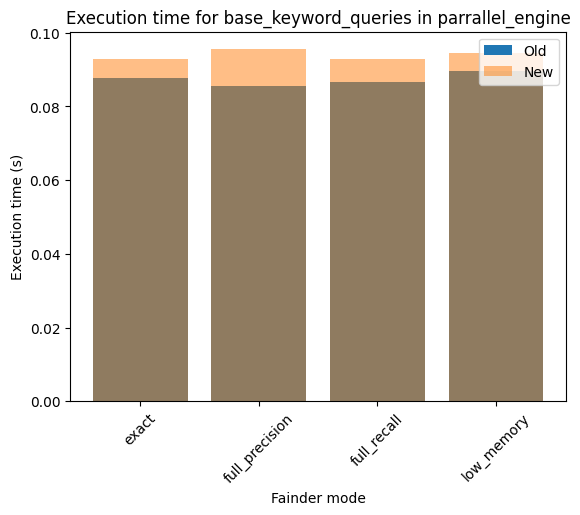

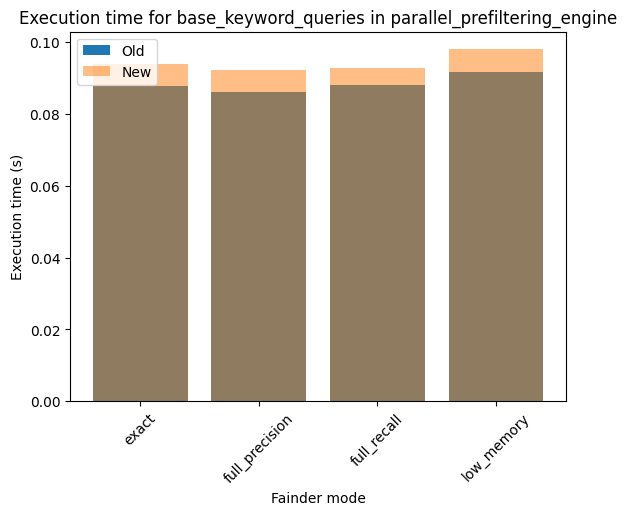

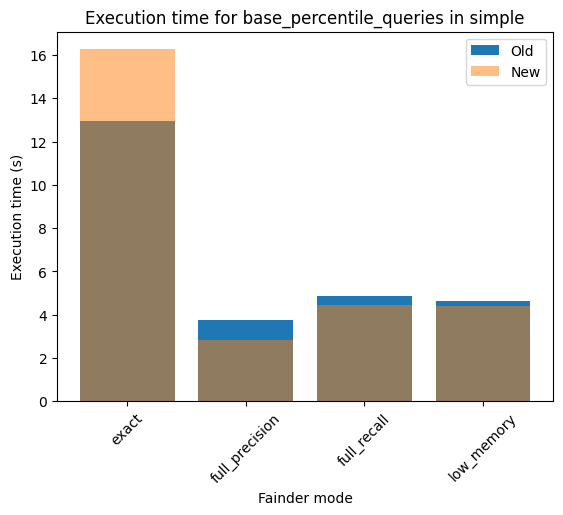

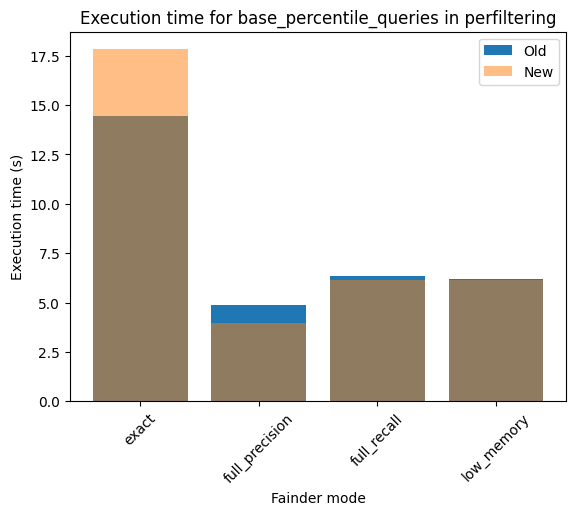

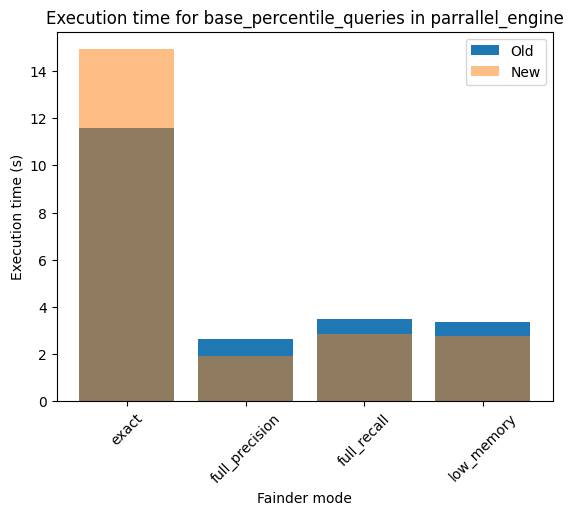

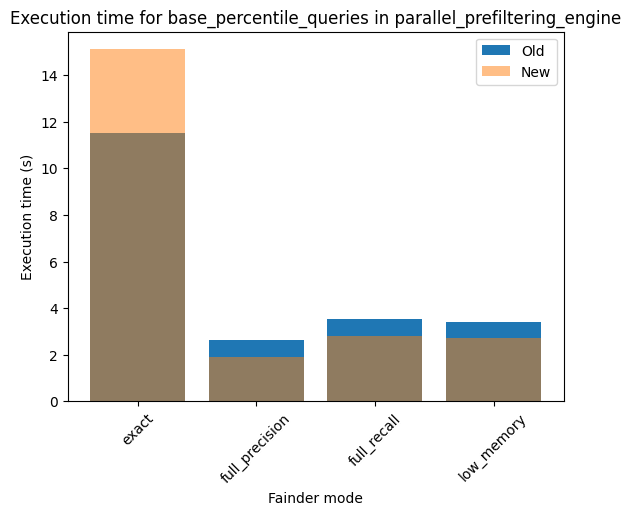

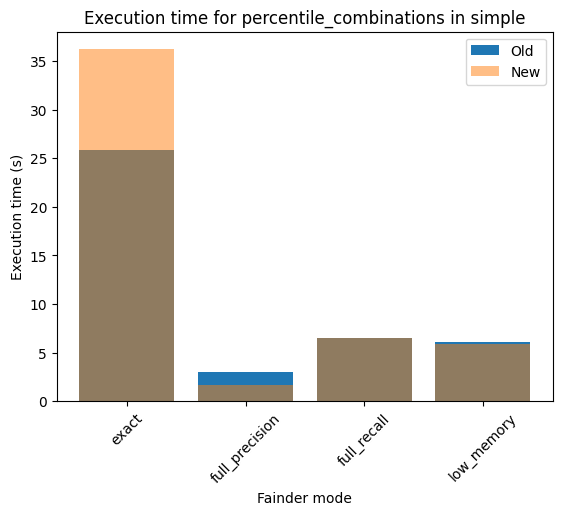

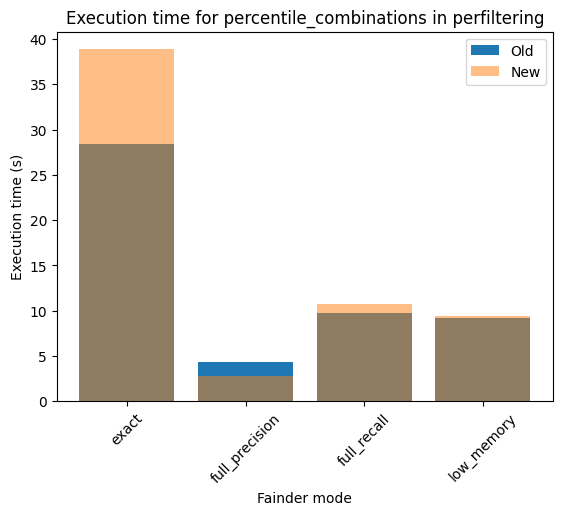

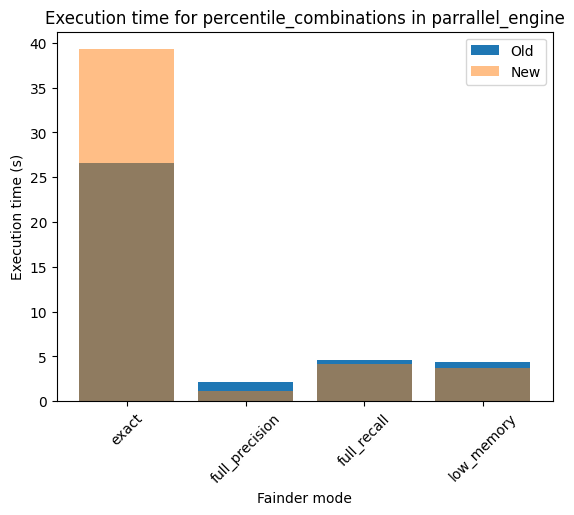

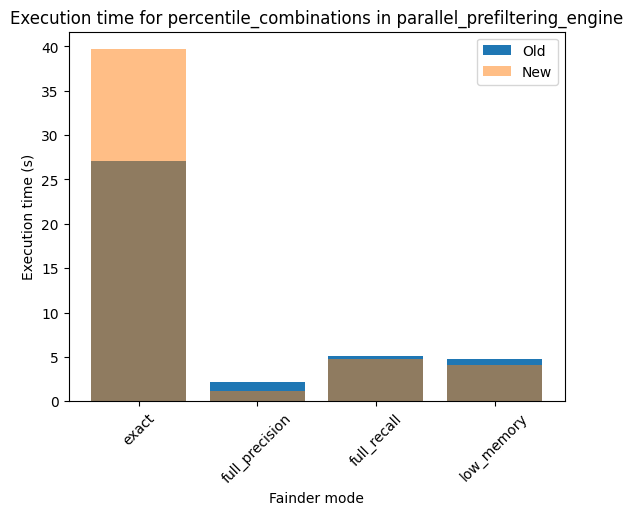

In [8]:
# For each category and fainder_mode (new plot) do a bar plot of the average execution time with scenario on the x-axis

scenarios = df_latest_new["scenario"].unique()
categories = df_latest_new["category"].unique()
fainder_modes = df_latest_new["fainder_mode"].unique()

for category in categories:
    for scenario in scenarios:
        df_latest_new_temp = df_latest_new[
            df_latest_new ["category"] == category
        ]
        df_latest_new_temp = df_latest_new_temp[
            df_latest_new_temp["scenario"] == scenario
        ]
        df_latest_old_temp = df_latest_old[
            df_latest_old["category"] == category
        ]
        df_latest_old_temp = df_latest_old_temp[
            df_latest_old_temp["scenario"] == scenario
        ]
        plt.figure()

        mean_execution_times_new = df_latest_new_temp.groupby("fainder_mode")["execution_time"].mean()

        mean_execution_times_old = df_latest_old_temp.groupby("fainder_mode")["execution_time"].mean()

        plt.bar(
            mean_execution_times_new.index,
            mean_execution_times_old.values,
        )

        plt.bar(
            mean_execution_times_new.index,
            mean_execution_times_new.values,
            alpha=0.5,
        )
        plt.title(f"Execution time for {category} in {scenario}")
        plt.xlabel("Fainder mode")
        plt.ylabel("Execution time (s)")

        plt.legend(["Old", "New"])
        plt.xticks(rotation=45)
        



